In [76]:
import numpy as np
import uuid
import pandas as pd
from collections import defaultdict
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

In [77]:
epochs = 50

In [78]:
df = pd.read_csv('../data/words_translations.csv')
df.shape

(54314, 10)

In [79]:
df = (df.
      pipe(lambda df: df[~df['rating'].isna()]).
      pipe(lambda df: df[df['rating'] > 0]).
      pipe(lambda df: df.assign(translation_created_at=pd.to_datetime(df['translation_created_at']))).
      pipe(lambda df: df.assign(word_created_at=pd.to_datetime(df['word_created_at']))).
      # create 100 bins (pd.date_rae(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs))
      pipe(lambda df: df.assign(bin=pd.cut(df['translation_created_at'], bins=epochs, labels=range(epochs)))).
      pipe(lambda df: df[~df['bin'].isna()]).
      pipe(lambda df: df.assign(word_n_words=df['word_body'].str.split().str.len())).
      pipe(lambda df: df[df['word_n_words'] == 1]).
      pipe(lambda df: df.assign(translation_n_words=df['translation_body'].str.split().str.len())).
      # only keep translations with 1 word
      pipe(lambda df: df[df['translation_n_words'] == 1]).
      # compute lengths in characters for each translation
      pipe(lambda df: df.assign(translation_len=df['translation_body'].str.len()))
)

In [80]:
# table with n of unique words and translations per bin
df_unique = df.groupby('bin').agg({'word_id': 'nunique', 'translation_id': 'nunique'}).reset_index()
df_unique.columns = ['bin', 'n_words', 'n_translations']

In [81]:
votes = pd.read_csv("../data/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
# votes['bin'] = pd.cut(votes['created_at'], bins=epochs, labels=range(epochs))
# use datettime from df to create identical bins ('translation_created_at') and label then with range(epochs)
votes['bin'] = pd.cut(votes['created_at'], bins=pd.date_range(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs+1), labels=range(epochs))
votes = votes[~votes['bin'].isna()]

In [82]:
votes

,user_id,translation_id,id,created_at,ip,bin
0,3039,13951,27276,2017-11-09 07:29:43.518325,NaN,19
1,3409,10817,27279,2017-11-09 09:17:16.096125,NaN,19
2,3409,1892,27280,2017-11-09 09:17:32.993409,NaN,19
3,3409,5696,27282,2017-11-09 09:28:50.963179,NaN,19
4,2940,829,27284,2017-11-09 10:19:30.529961,NaN,19
...,...,...,...,...,...,...
158233,9432,61430,189961,2023-06-03 21:57:16.750969,194.0.91.184,49
158234,9432,61464,189962,2023-06-03 21:57:41.538460,194.0.91.184,49
158235,9852,8008,189963,2023-06-03 21:58:02.179106,91.210.248.231,49
158236,9852,19309,189964,2023-06-03 21:58:44.617766,91.210.248.231,49


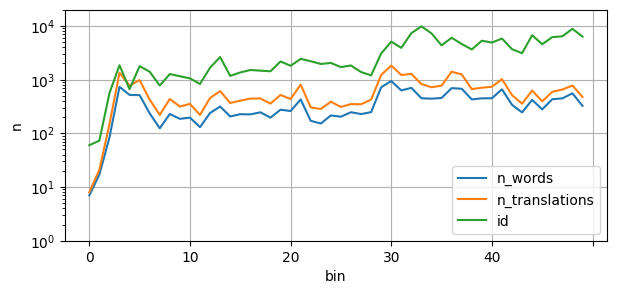

In [83]:
fig, ax = plt.subplots(figsize=(7, 3))
df_unique.plot(x='bin', y='n_words', ax=ax)
df_unique.plot(x='bin', y='n_translations', ax=ax)
votes.groupby('bin').agg({'id': 'nunique'}).plot(ax=ax, label='votes')
ax.set_xlabel('bin')
ax.set_ylabel('n')
# log y scale
ax.set_ylim(1, 20000)
ax.set_yscale('log')
plt.grid()
plt.legend()
plt.show()

In [84]:
# votes should have the same translations as df
votes = votes[votes['translation_id'].isin(df['translation_id'])]
# group by bin and user and count the number of votes
votes_ = votes.groupby(['bin', 'user_id']).size().reset_index(name='votes')
# for each bin, get the list of values in the column 'votes'
votes_ = votes_.query('votes > 0')
votes_ = votes_.groupby('bin')['votes'].apply(list).reset_index(name='votes')
# convert to dictionary
votes_ = votes_.set_index('bin')['votes'].to_dict()

In [85]:
n_words = df_unique['n_words'].to_numpy().round().astype(int)
n_translations = df_unique['n_translations'].to_numpy().astype(int)

In [97]:
# pickle n_words and n_translations
import pickle

with open('../data/n_words.pkl', 'wb') as f:
    pickle.dump(n_words, f)

with open('../data/n_translations.pkl', 'wb') as f:
    pickle.dump(n_translations, f)

# pickle df['translation_len'] as numpy array
translation_len = df['translation_len'].to_numpy().astype(int)
with open('../data/translation_len.pkl', 'wb') as f:
    pickle.dump(translation_len, f)

# and votes
with open('../data/votes.pkl', 'wb') as f:
    pickle.dump(votes_, f)

In [86]:
class SlovotvirModel:

    def __init__(self, 
                 words_series, 
                 translation_series, 
                 length_distr, 
                 votes_user, 
                 a, 
                 b):
        self.words_series = words_series
        self.translation_series = translation_series
        self.length_distr = length_distr
        self.votes_user = votes_user

        self.a = a
        self.b = b

        self.n_epochs = len(self.words_series)

        self.word_pool = defaultdict(list)
        self.translation_pool = defaultdict(dict)
                    
    def like_prob(self, 
                  lengths, 
                  likes):
        probs = (1/(lengths ** self.a)) + (1/(likes ** self.b))
        return probs

    def process_epoch(self, 
                      epoch):
        n_words = self.words_series[epoch]
        n_translations = self.translation_series[epoch]
        n_votes = self.votes_user[epoch]

        [self.word_pool[uuid.uuid1()] for _ in range(n_words)]

        unique_words = list(self.word_pool.keys())

        for _ in range(n_translations):
            word_id = np.random.choice(unique_words)
            translation_id = uuid.uuid1()
            self.word_pool[word_id].append(translation_id)
            self.translation_pool[translation_id] = {'length': np.random.choice(self.length_distr), 
                                                     'likes': 1}

        unique_words = list(self.word_pool.keys())

        likes_w = np.array([sum([self.translation_pool[translation_id]['likes'] for translation_id in 
                                 self.word_pool[word_id]]) for word_id in unique_words])

        likes_w = likes_w / likes_w.sum()

        for n in n_votes:
            for _ in range(n):
                translations = self.word_pool[np.random.choice(unique_words, p=likes_w)]

                while not translations:
                    translations = self.word_pool[np.random.choice(unique_words, p=likes_w)]

                lengths = np.array([self.translation_pool[translation_id]['length'] 
                                    for translation_id in translations]).astype(int)
                likes = np.array([self.translation_pool[translation_id]['likes'] 
                                  for translation_id in translations]).astype(int)

                ranks = np.argsort(np.argsort(likes)[::-1]) + 1

                probs = self.like_prob(lengths, ranks)
                probs = probs / probs.sum()

                tr = np.random.choice(translations, p=probs)
                self.translation_pool[tr]['likes'] += 1

    def run(self):
        for epoch in range(self.n_epochs):
            self.process_epoch(epoch)

In [87]:
def run_model(rng, a, b, size=None):
    m = SlovotvirModel(n_words, n_translations, df['translation_len'], votes_, a, b)
    m.run()

    likes = [m.translation_pool[tr]['likes'] for tr in m.translation_pool.keys()]
    ranked = np.argsort(likes)[::-1]

    return np.array(likes)[ranked]

In [88]:
true_likes = df['rating'].to_numpy()
true_ranked = np.argsort(true_likes)[::-1]

In [89]:
true_likes[true_ranked]

array([392., 354., 339., ...,   1.,   1.,   1.])

### ABC

In [90]:
import pymc as pm
import arviz as az

In [91]:
data = np.array(true_likes[true_ranked]).astype(int)

In [95]:
with pm.Model() as example:
    a = pm.Poisson("a", mu=0.5)
    b = pm.Poisson("b", mu=1.5)
    s = pm.Simulator("s", run_model, params=(a, b), sum_stat="identity", epsilon=1, observed=data)

    idata = pm.sample_smc(progressbar=False, draws=50, cores=10)
    idata.extend(pm.sample_posterior_predictive(idata))

Initializing SMC sampler...
Sampling 10 chains in 10 jobs


KeyboardInterrupt: 

array([[<Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'a'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'b'}>,
        <Axes: title={'center': 'b'}, xlabel='Rank (all chains)'>]],
      dtype=object)

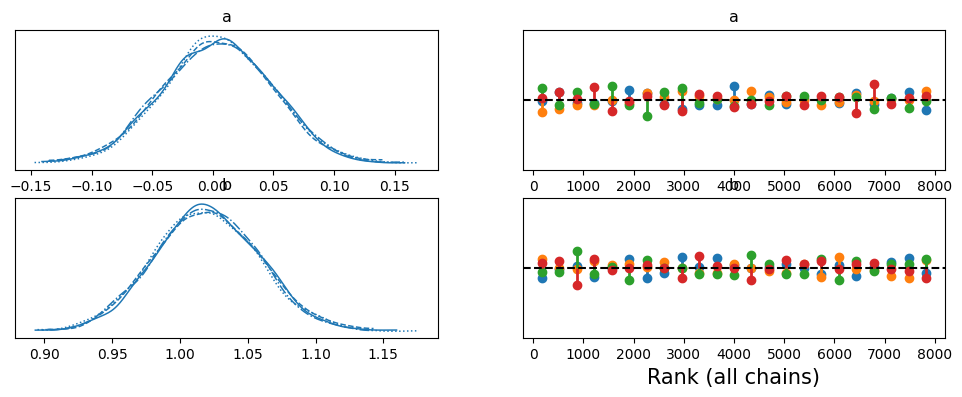

In [ ]:
az.plot_trace(idata, kind="rank_vlines")